<a href="https://colab.research.google.com/github/pireylow/stock-price-prediction-LSTM-ARIMA/blob/main/LSTM_Day_by_Day_Model_with_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!pip install yfinance

In [28]:
import random
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import yfinance as yf
yf.pdr_override()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [29]:
#set stock information
ticker = 'SPY'
startdate = '2018-01-01'
enddate = '2023-01-01'

start = pd.to_datetime(startdate)
end = pd.to_datetime(enddate)
sdata = pdr.get_data_yahoo(ticker, start=start, end=end)

columnsTitles=['Open','High','Low','Close','Volume','Adj Close']
sdata=sdata.reindex(columns=columnsTitles)

close=sdata['Close']
close.describe()

[*********************100%***********************]  1 of 1 completed


count    1259.000000
mean      344.338904
std        66.595683
min       222.949997
25%       283.980011
50%       326.859985
75%       402.525009
max       477.709991
Name: Close, dtype: float64

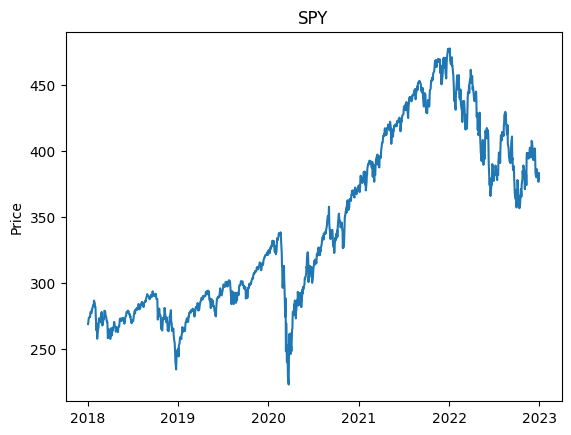

In [30]:
#simple plot for double check of data
plt.title(ticker)
plt.plot(sdata['Close'])
plt.ylabel('Price')
plt.show()

In [31]:
sdata

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989,86655700,244.918671
2018-01-03,268.959991,270.640015,268.959991,270.470001,90070400,246.467850
2018-01-04,271.200012,272.160004,270.540009,271.609985,80636400,247.506668
2018-01-05,272.510010,273.559998,271.950012,273.420013,83524000,249.156021
2018-01-08,273.309998,274.100006,272.980011,273.920013,57319200,249.611618
...,...,...,...,...,...,...
2022-12-23,379.649994,383.059998,378.029999,382.910004,59857300,380.042480
2022-12-27,382.790009,383.149994,379.649994,381.399994,51638200,378.543793
2022-12-28,381.329987,383.390015,376.420013,376.660004,70911500,373.839264


In [32]:
#create price data set
Y = sdata.iloc[:,3].values
final_dataset = Y.reshape(len(Y),1) #scaler needs two dimensions

ntrvals = 1230
train_data=final_dataset[0:ntrvals,:]
test_data=final_dataset[ntrvals:,:]

#create a list of past values (including training data -- true test value will be added one by one)
history = [x for x in train_data]
model_predictions = []
N_test_observations = len(test_data)

#loop over every data point for testing data
for time_point in range(N_test_observations):
  scaler=MinMaxScaler(feature_range=(0,1))
  scaled_data=scaler.fit_transform(final_dataset)

  blocksize=60
  x_train_data,y_train_data=[],[]
  for i in range(blocksize,len(train_data)):
      x_train_data.append(scaled_data[i-blocksize:i,0])
      y_train_data.append(scaled_data[i,0])

  x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)
  print(x_train_data.shape)
  x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))
  print(x_train_data.shape)

  lstm_model=Sequential()
  lstm_model.add(LSTM(units=100,input_shape=(x_train_data.shape[1],1)))
  lstm_model.add(Dense(1))

  lstm_model.compile(loss='mean_squared_error',optimizer='adam')
  lstm_model.summary()

  lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

  inputs_data=scaled_data[len(final_dataset)-len(test_data)-blocksize :,:]

  X_test=[]
  Y_test=[]

  i=blocksize + time_point
  X_test.append(inputs_data[i-blocksize:i,0])
  Y_test.append(inputs_data[i,0])

  X_test=np.array(X_test)
  Y_test=np.array(Y_test)

  predicted_closing_price=lstm_model.predict(X_test)
  predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

  model_predictions.append(predicted_closing_price)
  true_test_value = test_data[time_point]
  history.append(true_test_value)


(1170, 60)
(1170, 60, 1)
Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_58 (LSTM)              (None, 100)               40800     
                                                                 
 dense_58 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
1170/1170 - 25s - loss: 0.0031 - 25s/epoch - 21ms/step
1/1 [==============================] - 0s 331ms/step
(1170, 60)
(1170, 60, 1)
Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_59 (LSTM)              (None, 100)               40800     
                                                                 


In [33]:
model_predictions = [x[0] for x in model_predictions]
MSE_error = mean_squared_error(test_data, model_predictions)
print('Mean Squared Error For the Test Data: {}'.format(MSE_error))

Mean Squared Error For the Test Data: 64.20101222251381


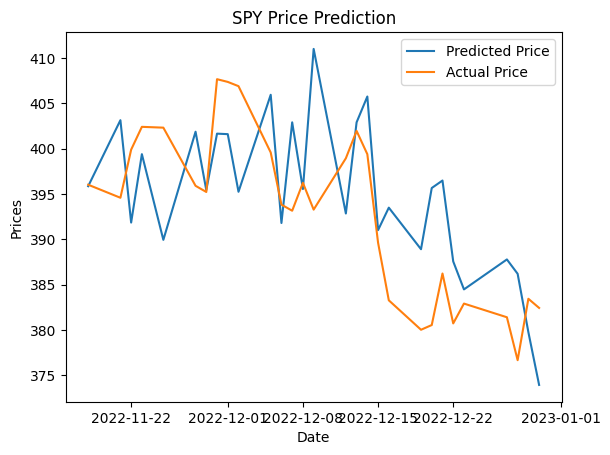

In [34]:
test_set_range = sdata[1230:].index
plt.plot(test_set_range, model_predictions,label='Predicted Price')
plt.plot(test_set_range, test_data, label='Actual Price')
plt.title(ticker + ' Price Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()